##    Análise de Desempenho de Vendas e Calculadora de Previsão de Vendas
O objetivo deste projeto é fornecer ferramentas para analisar o desempenho de vendas históricas e prever vendas futuras com base em dados passados. A análise de desempenho ajuda a identificar tendências, pontos fortes e áreas de melhoria, enquanto a calculadora de previsão de vendas utiliza algoritmos para estimar vendas futuras, auxiliando na tomada de decisões estratégicas.

In [133]:
!pip install pandas numpy scikit-learn matplotlib seaborn

###Importando as bibliotecas

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

###Criar o conjunto de dados


In [135]:
# Gerar o dataframe com dados de vendas para 36 meses com tendência e sazonalidade
np.random.seed(42)
months = pd.date_range('2021-01-01', periods=36, freq='M')
sales = [random.randint(150, 500) + (i%12)*20 + (i//12)*100 for i in range(36)]  # Com tendência e sazonalidade

df = pd.DataFrame({
    'date': months,
    'sales': sales
})

# Criar colunas de características temporais
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['year_month'] = df['date'].dt.year * 12 + df['date'].dt.month

# Visualizar as primeiras linhas
print(df.head())


        date  sales  year  month  day_of_week  quarter  year_month
0 2021-01-31    356  2021      1            6        1       24253
1 2021-02-28    422  2021      2            6        1       24254
2 2021-03-31    449  2021      3            2        1       24255
3 2021-04-30    329  2021      4            4        2       24256
4 2021-05-31    414  2021      5            0        2       24257


<ipython-input-135-f979d38dbaa5>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range('2021-01-01', periods=36, freq='M')


##### Data Exploration e visualização

In [136]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         36 non-null     datetime64[ns]
 1   sales        36 non-null     int64         
 2   year         36 non-null     int32         
 3   month        36 non-null     int32         
 4   day_of_week  36 non-null     int32         
 5   quarter      36 non-null     int32         
 6   year_month   36 non-null     int32         
dtypes: datetime64[ns](1), int32(5), int64(1)
memory usage: 1.4 KB


,date,sales,year,month,day_of_week,quarter,year_month
count,36,36.000000,36.000000,36.00000,36.000000,36.000000,36.000000
mean,2022-07-15 22:00:00,573.305556,2022.000000,6.50000,2.972222,2.500000,24270.500000
min,2021-01-31 00:00:00,329.000000,2021.000000,1.00000,0.000000,1.000000,24253.000000
25%,2021-10-23 06:00:00,454.250000,2021.000000,3.75000,1.000000,1.750000,24261.750000
50%,2022-07-15 12:00:00,580.000000,2022.000000,6.50000,3.000000,2.500000,24270.500000
75%,2023-04-07 12:00:00,669.750000,2023.000000,9.25000,5.000000,3.250000,24279.250000
max,2023-12-31 00:00:00,897.000000,2023.000000,12.00000,6.000000,4.000000,24288.000000
std,NaN,146.447225,0.828079,3.50102,2.063092,1.133893,10.535654


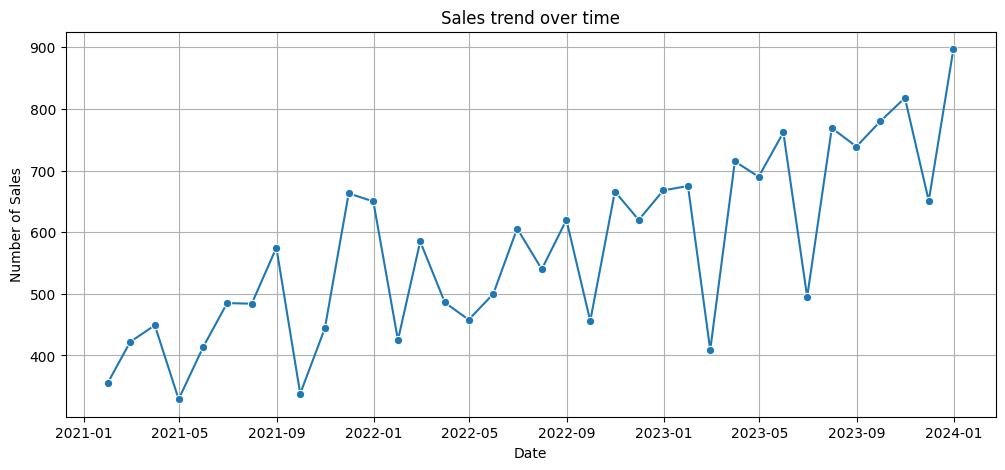

In [137]:
plt.figure(figsize=(12, 5)) #Lagura 12, altura 5
sns.lineplot(x=df['date'], y=df['sales'], marker='o') #criar um graf de linha c/ os dados de vendas
plt.title("Sales trend over time") #titutlop
plt.xlabel("Date") # nome do eixo
plt.ylabel("Number of Sales")
plt.grid(True) #adc grade p facilitar a visualização
plt.show()

####Preparar a data p/ treinar o modelo

##### Treinar p modelos de predicao

In [138]:
X = df[['year', 'month', 'day_of_week', 'quarter', 'year_month']]  # Features
y = df['sales']  # Target


# Dividir os dados 80/20 sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [139]:
model = LinearRegression()
model.fit(X_train, y_train)

#verificar os coeficientes

print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")

Intercept: -194656.52054111435
Coefficients: [  1.15267703  -5.88707837 -10.57190757  51.42626692   7.94504605]


In [144]:
# Ajustando os parâmetros do Random Forest
rf_model = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar a performance do modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'R²: {r2:.2f}')

MAE: 0.12
MSE: 0.02
R²: 0.62


In [145]:
def predict_sales(year, month, day_of_week, quarter, year_month):
    input_data = pd.DataFrame([[year, month, day_of_week, quarter, year_month]],
                              columns=['year', 'month', 'day_of_week', 'quarter', 'year_month'])
    prediction = rf_model.predict(input_data)
    return round(scaler.inverse_transform(prediction.reshape(-1, 1))[0][0], 2)

test_year = 2024
test_month = 6
day_of_week = 0
quarter = 2
year_month = test_year * 12 + test_month
forecast = predict_sales(test_year, test_month, day_of_week, quarter, year_month)
print(f"Predicted sales for {test_month}/{test_year}: {forecast:.2f}")

Predicted sales for 6/2024: 763.30


#Aprendizado

Consegui gerar dados de forma consistente
Usei corretamente  as métricas
Predict_sales funcinou bem

Erros:
O modelo escolhido nao foi o melhor, o que resultou num resultado que nao dava um feat. Para essa situacao era extremamente necessario sazonalidade/ tendencia logo usando o RandomForestRegressor.